## Resampling Sentinel-2 Bands with Different Resolutions Using OpenEO
### Introduction

In geospatial analysis, working with multi-band data from satellite imagery often involves dealing with bands of varying resolutions. This is particularly true for Sentinel-2 data, where different bands have different spatial resolutions. To combine these bands into a single data cube for analysis, we must first resample them to a common resolution. In this tutorial, we will demonstrate how to load two Sentinel-2 bands with different resolutions, resample one of the bands, and create a data cube using the OpenEO Python client.
## Objective

### The objective of this tutorial is to:
- Load two Sentinel-2 bands with different spatial resolutions.
- Resample one of the bands to match the resolution of the other.
- Create a data cube that combines the two resampled bands.

### In this notebook, you will explore the following concepts:

A. **Loading Sentinel-2 Bands:** Using OpenEO to load Sentinel-2 bands with different resolutions.
B. **Resampling Data Cubes:** Applying resampling techniques to adjust the resolution of one band to match the other.
C. **Creating a Multi-band Data Cube**: Combining the resampled bands into a single data cube.

### Tools You'll Use:

- **OpenEO**: To interact with satellite data and perform spatial operations.
- **Xarray**: For managing and analyzing multi-dimensional data arrays.
- **Matplotlib**: For visualizing the results of your analysis.

### Learning Outcomes:

By the end of this tutorial, you will be able to:

- Load Sentinel-2 bands with different resolutions using OpenEO.
- Resample one band to match the resolution of another using various interpolation methods.
- Create and visualize a multi-band data cube.

In [1]:
from config import eo_service_url,user,passwd
from demo_regions import  s2

## A. Loading Sentinel-2 Bands

We start by connecting to the OpenEO backend and loading two Sentinel-2 bands: one with 10m resolution (e.g., B04) and another with 20m resolution (e.g., B11).

In [2]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt

# Connect to OpenEO
#conn = openeo.connect(eo_service_url)
conn = openeo.connect("http://host.docker.internal:8000")

# Authenticate (replace with your credentials or use OAuth if available)
conn.authenticate_basic(username=user, password=passwd)

# Define the collection and bands to load
collection = s2.s2_msi_l2a
band_10m = "b04"  # Red band, 10m resolution
band_20m = "b11"  # SWIR band, 20m resolution

# Define a bounding box for the area of interest
bbox = {
          "west": 13.460930954751282,
          "east": 13.585449709728213,
          "south": 59.36327761288911,
          "north": 59.40107161575003
        }
timespan=["2024-06-12", "2024-06-13"]
# Load the data for both bands
datacube_10m = conn.load_collection(collection, bands=[band_10m], temporal_extent=timespan, spatial_extent=bbox)
datacube_20m = conn.load_collection(collection, bands=[band_20m], temporal_extent=timespan, spatial_extent=bbox)


Note that the above code only creates the process trees to send to the back-end. Nothing has been fetched yet.
## B. Resampling the 10m Band to 20m Resolution

Since the datacubes must have the same resolution, we need to resample the 10m band to match the 20m resolution of the other band

In [15]:
# Resample the 20m datacube to 10m resolution
resampled_10m = datacube_10m.resample_cube_spatial(target=datacube_20m, method='bilinear')


### Interpolation Methods:

- **Nearest Neighbor** (`near`): Fastest but may result in blocky artifacts.
- **Bilinear** (`bilinear`): A good balance between performance and smoothing.
- **Cubic** (`cubic`): Produces smoother results but is computationally more expensive.
- **Cubic Spline** (`cubicspline`): Very smooth, suitable for continuous data; more computationally intensive.
- **Lanczos** (`lanczos`): Sharp, high-quality interpolation; more computationally expensive, good for resampling imagery.
- **Average** (`average`): Useful for downsampling; averages the values in the neighborhood.
- **Mode** (`mode`): Picks the most frequent value in the neighborhood; useful for categorical data.
- **Maximum** (`max`): Selects the maximum value in the neighborhood.
- **Minimum** (`min`): Selects the minimum value in the neighborhood.
- **Median** (`med`): Selects the median value in the neighborhood.
- **First Quartile** (`q1`): Selects the first quartile value in the neighborhood.
- **Third Quartile** (`q3`): Selects the third quartile value in the neighborhood.


You can choose any of these methods depending on your needs.

## C. Creating a Multi-band Data Cube

Now that both bands have the same resolution, we can combine them into a single data cube.

In [16]:
# Merge the datacubes into a single multi-band cube
multi_band_cube = datacube_20m.merge_cubes(resampled_10m)

multi_band_cube


In [17]:
# This is typically a too big job for execute or download
job = multi_band_cube.create_job(out_format='netcdf',title="Combine bands of different resolution")

In [18]:
display(job)

<BatchJob job_id='5b58e62e-4f32-486e-a297-aac90ffe72ac'>

In [19]:
job.start_and_wait()

0:00:00 Job '5b58e62e-4f32-486e-a297-aac90ffe72ac': send 'start'
0:00:00 Job '5b58e62e-4f32-486e-a297-aac90ffe72ac': queued (progress 0.0%)
0:00:05 Job '5b58e62e-4f32-486e-a297-aac90ffe72ac': running (progress 0.0%)
0:00:11 Job '5b58e62e-4f32-486e-a297-aac90ffe72ac': finished (progress 0.0%)


<BatchJob job_id='5b58e62e-4f32-486e-a297-aac90ffe72ac'>

In [20]:
job.logs()

[{'id': '950',
  'level': 'info',
  'message': 'Job Created',
  'time': '2024-10-24T05:31:20.827840Z'},
 {'id': '952',
  'level': 'info',
  'message': 'Worker received job for execution.',
  'time': '2024-10-24T05:31:22.744053Z',
  'data': {'worker': 'EOW-2024-09-12-14:39--dfm-nbs-EEQOEK'}},
 {'id': '953',
  'level': 'info',
  'message': 'Worker completed job with status finished.',
  'time': '2024-10-24T05:31:33.190258Z',
  'data': {'stderr': '',
   'stdout': "Executing process graph:\nSaving result of type <class 'xarray.core.dataarray.DataArray'>. \nProcess graph executed\n",
   'worker': 'EOW-2024-09-12-14:39--dfm-nbs-EEQOEK'},
  'usage': {'duration': {'value': 10298.0, 'unit': 'ms'},
   'storage': {'value': 0.0, 'unit': 'bytes'}}},
 {'id': '951',
  'level': 'info',
  'message': 'Job start execution requested.',
  'time': '2024-10-24T05:31:21.578771Z'}]

In [21]:
job.get_results()

<JobResults for job '5b58e62e-4f32-486e-a297-aac90ffe72ac'>

In [22]:
results = job.get_results()

In [23]:
results.download_files()

[PosixPath('/proj/tutorials/workshop_W2443/process.json'),
 PosixPath('/proj/tutorials/workshop_W2443/summary.nc'),
 PosixPath('/proj/tutorials/workshop_W2443/stac.json'),
 PosixPath('/proj/tutorials/workshop_W2443/5b58e62e-4f32-486e-a297-aac90ffe72ac.txt'),
 PosixPath('/proj/tutorials/workshop_W2443/py_proc_std_err.txt'),
 PosixPath('/proj/tutorials/workshop_W2443/py_proc_std_out.txt'),
 PosixPath('/proj/tutorials/workshop_W2443/job-results.json')]

In [25]:
ds = xr.open_dataset("summary.nc")
ds

<xarray.Dataset> Size: 1MB
Dimensions:      (t: 1, y: 219, x: 359)
Coordinates:
  * t            (t) datetime64[ns] 8B 2024-06-12T10:30:31.024000
  * y            (y) float64 2kB 6.586e+06 6.586e+06 ... 6.581e+06 6.581e+06
  * x            (x) float64 3kB 4.125e+05 4.125e+05 ... 4.196e+05 4.197e+05
    spatial_ref  int64 8B ...
Data variables:
    b11          (t, y, x) float64 629kB ...
    b04          (t, y, x) float64 629kB ...
Attributes:
    collection:  s2_msi_l2a
    nodata:      -9999
    crs:         EPSG:3006

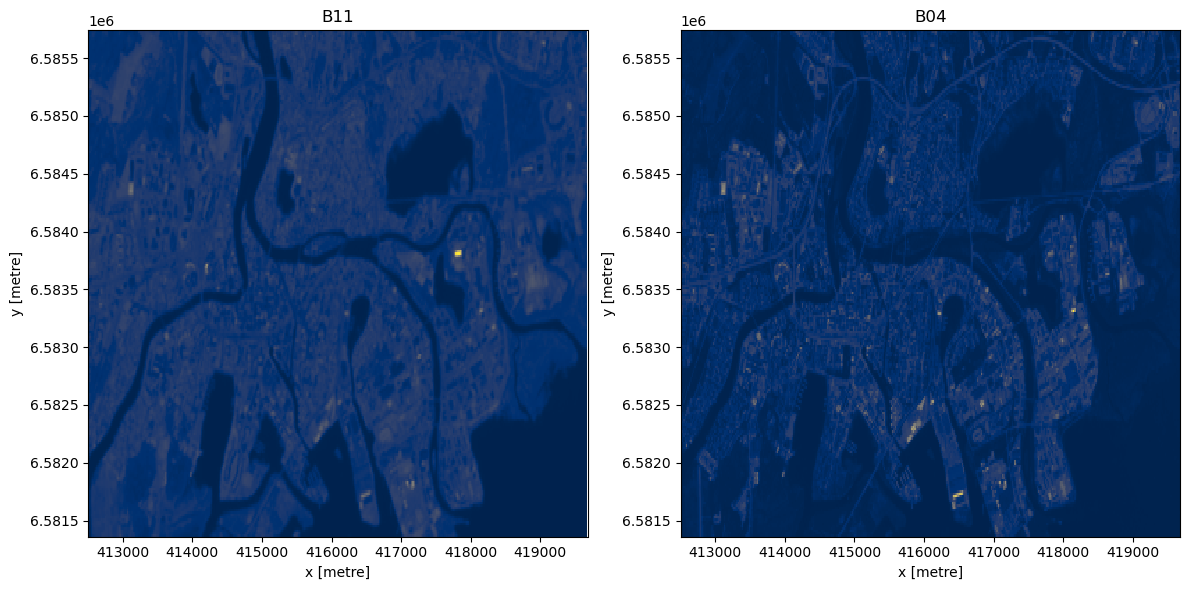

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ds['b11'].plot(ax=axes[0], cmap='cividis',add_colorbar=False)
axes[0].set_title('B11')

ds['b04'].plot(ax=axes[1], cmap='cividis',add_colorbar=False)
axes[1].set_title('B04')

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've demonstrated how to load Sentinel-2 bands with different resolutions, resample one band to match the resolution of the other, and combine them into a single data cube using the OpenEO Python client. The choice of interpolation method for resampling can affect the results, so it's important to consider the trade-offs between speed and accuracy.
Next Steps

You can extend this workflow by applying further analyses to the multi-band data cube, such as computing vegetation indices or classifying land cover types.

In [13]:
job.delete()